In [1]:
# Other imports
import numpy as np
import torch
import sys
from sklearn.metrics import classification_report

from collections import Counter
from datetime import datetime
import pdb
sys.path.append('..')

# DeepCASE Imports
from deepcase.preprocessing   import Preprocessor
from deepcase.context_builder import ContextBuilder
from deepcase.interpreter     import Interpreter

import matplotlib.pyplot as plt

[Epoch 100/100 loss=0.047791]: 100%|██████████| 30/30 [00:00<00:00, 53.51it/s]
/home/jia/anaconda3/envs/mytorch1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jia/anaconda3/envs/mytorch1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jia/anaconda3/envs/mytorch1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

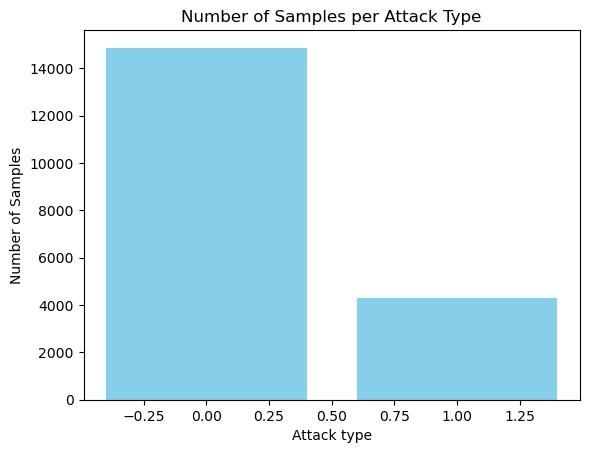

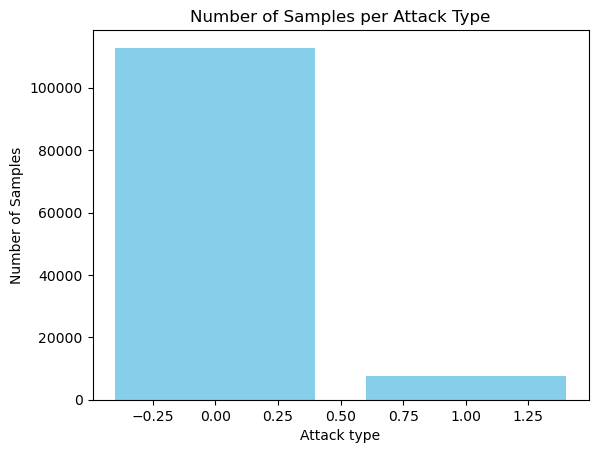

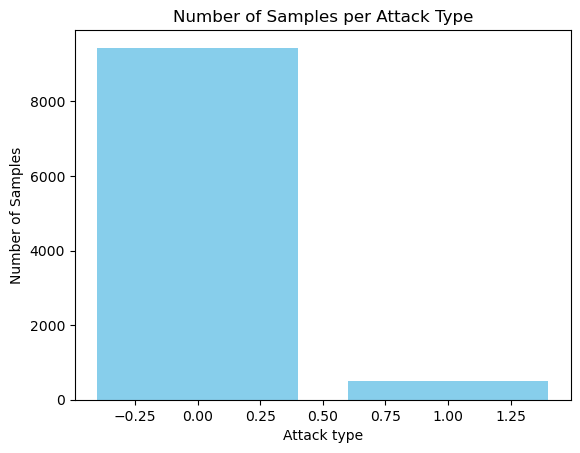

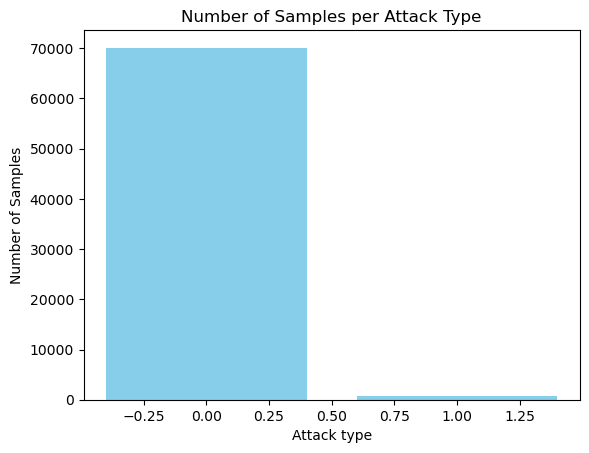

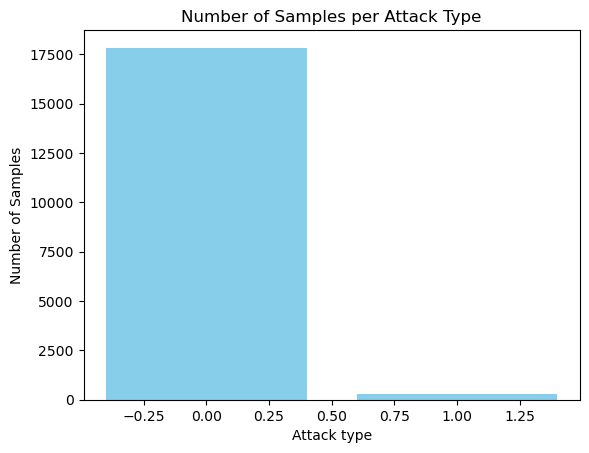

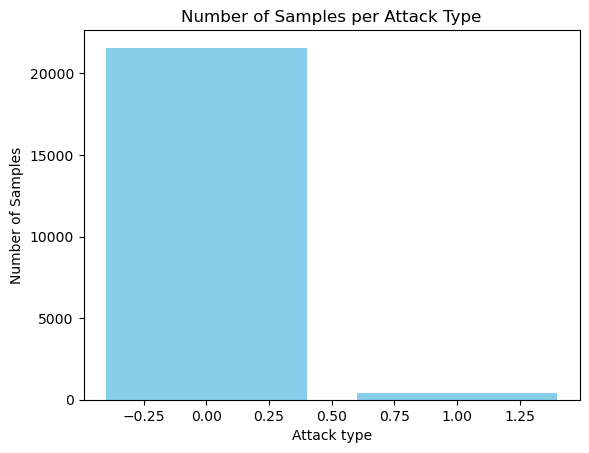

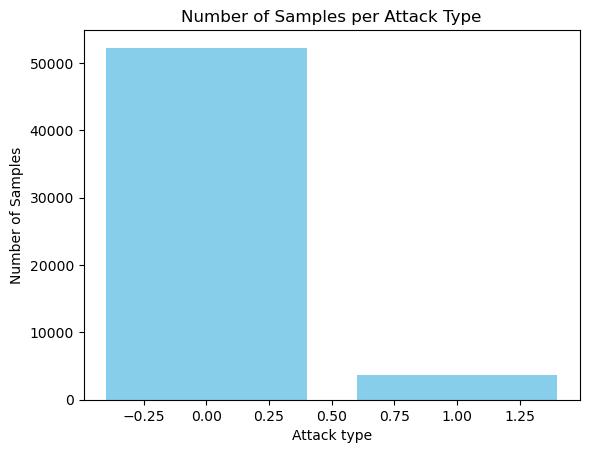

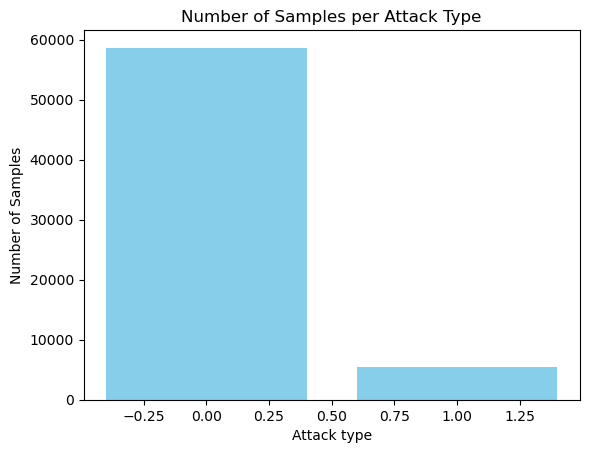

In [2]:
########################################################################
#                             Loading data                             #
########################################################################

# define dictionary of parameters

context_length = 10
# Create preprocessor
preprocessor = Preprocessor(
    length  = context_length,    # 10 events in context
    timeout = 86400, # Ignore events older than 1 day (60*60*24 = 86400 seconds)
)

# Load data from file
scenarios = {
    'fox_alerts' : '../../../datasets/ait_alerts_csv/alerts_csv/fox_alerts.txt', \
    'harrison_alerts' : '../../../datasets/ait_alerts_csv/alerts_csv/harrison_alerts.txt',\
    'russellmitchell_alerts' : '../../../datasets/ait_alerts_csv/alerts_csv/russellmitchell_alerts.txt',\
    'santos_alerts' : '../../../datasets/ait_alerts_csv/alerts_csv/santos_alerts.txt',\
    'shaw_alerts' : '../../../datasets/ait_alerts_csv/alerts_csv/shaw_alerts.txt',\
    'wardbeck_alerts' : '../../../datasets/ait_alerts_csv/alerts_csv/wardbeck_alerts.txt',\
    'wheeler_alerts' : '../../../datasets/ait_alerts_csv/alerts_csv/wheeler_alerts.txt',\
    'wilson_alerts' : '../../../datasets/ait_alerts_csv/alerts_csv/wilson_alerts.txt'
}


for name,p in scenarios.items():
    # print information
    current_time = datetime.now()
    formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
    
    with open('test8sce.txt','a') as f:
        print('*' * 50,file=f)
        print(f"Formatted Date and Time:{formatted_time}",file=f )
        print(f'Scenarios:{name}',file=f)
        print('*' * 50, file = f)
    


    context, events, mapping, mapping_label, labels  = preprocessor.text(p)

    events = torch.tensor(np.array(events))
    labels = torch.tensor(np.array(labels))

    if labels is None:
        labels = np.full(events.shape[0], -1, dtype=int)

# Cast to cuda if available
    if torch.cuda.is_available():   
        events  = events.to('cuda')
        context = context.to('cuda')

    with open('test8sce.txt','a') as f:
        print(f'the total number of samples: {len(labels)}',file = f)
        print(f'the number of false positive: {sum(labels==0)}',file = f)
        print(f'the number of analomal samples: {sum(labels==1)} ',file = f)

# draw the distributions
    counter_bin = Counter(np.array(labels))
    labels_bin = list(counter_bin.keys())
    values_bin = list(counter_bin.values())

    plt.figure()
    plt.bar(labels_bin,values_bin,color='skyblue')
    plt.xlabel("Attack type")
    plt.ylabel("Number of Samples")
    plt.title("Number of Samples per Attack Type")
    plt.savefig('./figs/'+name)

    events_train  = events [:events.shape[0]//5 ]
    events_test   = events [ events.shape[0]//5:]

    context_train = context[:events.shape[0]//5 ]
    context_test  = context[ events.shape[0]//5:]

    labels_train_binary  = labels[:events.shape[0]//5 ]
    labels_test_binary   = labels[ events.shape[0]//5:]


    vocab_size = len(np.unique(list(mapping)))
    context_builder = ContextBuilder(
        input_size    = vocab_size,   # Number of input features to expect
        output_size   = vocab_size,   # Same as input size
        hidden_size   = 128,   # Number of nodes in hidden layer, in paper we set this to 128
        max_length    = context_length,    # Length of the context, should be same as context in Preprocessor
    )

    # Cast to cuda if available
    if torch.cuda.is_available():
        context_builder = context_builder.to('cuda')

    # Train the ContextBuilder
    context_builder.fit(
        X             = context_train,               # Context to train with
        y             = events_train.reshape(-1, 1), # Events to train with, note that these should be of shape=(n_events, 1)
        labels        = labels_train_binary,
        epochs        = 100,                          # Number of epochs to train with
        batch_size    = 128,                         # Number of samples in each training batch, in paper this was 128
        learning_rate = 0.001,                        # Learning rate to train with, in paper this was 0.01
        verbose       = True,                        # If True, prints progress
    )

    confidence_test, _ = context_builder.predict(context_test)
    predicted_test    = torch.argmax(confidence_test.squeeze(1),dim=1).to('cpu').numpy()

    events_test_np = events_test.to('cpu').numpy()

    with open('test8sce.txt','a') as f:
        print(classification_report(events_test_np, predicted_test,digits=4),file=f)